# **Proyecto BigData - Entrega 1**
# **Juan Esteban Salazar Toro - 2221681**

El dataset que seleccioné es el de Diabetes Health Indicators, disponible en Kaggle. Lo elegí porque aborda un tema de alto impacto en salud pública: la diabetes. Este conjunto de datos incluye variables relacionadas con el estilo de vida y condiciones físicas de los pacientes, como el índice de masa corporal (IMC), actividad física, hábitos alimenticios, consumo de alcohol y antecedentes de enfermedades crónicas. La tarea planteada es de clasificación, ya que el objetivo es predecir si una persona tiene o no diabetes a partir de estos indicadores.

**Link:** https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

# **Inicialización e Importación de DataSet**

In [ ]:
!pip install -q pyspark
!pip install -q findspark

In [ ]:
import zipfile
import os, pathlib, PIL, shutil, glob
from google.colab import files

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.window as W
import pyspark.sql.types as T

import seaborn as sns
import matplotlib.pyplot as plt

from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
from yellowbrick.classifier import ROCAUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanessalazar","key":"554375efc9ce9cf94e590bbf82767554"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset
!ls

Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
License(s): CC0-1.0
  0% 0.00/6.03M [00:00<?, ?B/s]
100% 6.03M/6.03M [00:00<00:00, 726MB/s]
diabetes-health-indicators-dataset.zip	kaggle.json  sample_data


In [ ]:
zip_ref = zipfile.ZipFile('diabetes-health-indicators-dataset.zip', 'r') #localizar el nombre del archivo .zip y colocarlo
zip_ref.extractall('Data') #Extracción de archivos descargados en una carpeta llamada 'files', podria ser cualquier nombre
zip_ref.close()

In [ ]:
spark = SparkSession.builder.appName("Proyecto").getOrCreate()
spark

In [ ]:
datos = spark.read.csv('/content/Data/diabetes_binary_health_indicators_BRFSS2015.csv',inferSchema=True, header=True)
datos.show(5, truncate=False)
datos.printSchema()

+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|Diabetes_binary|HighBP|HighChol|CholCheck|BMI |Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age |Education|Income|
+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|0.0            |1.0   |1.0     |1.0      |40.0|1.0   |0.0   |0.0                 |0.0         |0.0   |1.0    |0.0              |1.0          |0.0        |5.0    |18.0    |15.0    |1.0     |0.0|9.0 |4.0      |3.0   |
|0.0            |0.0   |0.0     |0.0      |25.0|1.0   |0.0   |0.0                 |1.0         |0.0   |0.0    |0.0              |0.0

# **Depuración de Datos**

Como este análisis busca entender qué factores físicos y de estilo de vida influyen en el desarrollo de la diabetes, se decidió dejar por fuera las variables demográficas o con poca relevancia para este enfoque.

In [ ]:
datos_f1 = datos.drop("NoDocbcCost", "PhysHlth", "AnyHealthcare","MentHlth", "Education", "Income")
datos_f1.show(5, truncate=False)

+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------+--------+---+----+
|Diabetes_binary|HighBP|HighChol|CholCheck|BMI |Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|GenHlth|DiffWalk|Sex|Age |
+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------+--------+---+----+
|0.0            |1.0   |1.0     |1.0      |40.0|1.0   |0.0   |0.0                 |0.0         |0.0   |1.0    |0.0              |5.0    |1.0     |0.0|9.0 |
|0.0            |0.0   |0.0     |0.0      |25.0|1.0   |0.0   |0.0                 |1.0         |0.0   |0.0    |0.0              |3.0    |0.0     |0.0|7.0 |
|0.0            |1.0   |1.0     |1.0      |28.0|0.0   |0.0   |0.0                 |0.0         |1.0   |0.0    |0.0              |5.0    |1.0     |0.0|9.0 |
|0.0            |1.0   |0.0     |1.0      |27.0|0.0   |0.0   |0.

In [ ]:
def faltantes(df):
  falta = df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns])
  return falta.show()

In [ ]:
faltantes(datos_f1)

+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------+--------+---+---+
|Diabetes_binary|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|GenHlth|DiffWalk|Sex|Age|
+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------+--------+---+---+
|              0|     0|       0|        0|  0|     0|     0|                   0|           0|     0|      0|                0|      0|       0|  0|  0|
+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------+--------+---+---+



# **EDA**

In [ ]:
numeric_features = [t[0] for t in datos_f1.dtypes if t[1] == 'int' or t[1] == 'double']
datos_f1.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Diabetes_binary,253680,0.13933301797540207,0.34629438458921147,0.0,1.0
HighBP,253680,0.4290011037527594,0.49493446268990043,0.0,1.0
HighChol,253680,0.4241209397666351,0.49420980465688596,0.0,1.0
CholCheck,253680,0.9626695048880479,0.18957075436272514,0.0,1.0
BMI,253680,28.382363607694735,6.608694201406001,12.0,98.0
Smoker,253680,0.44316855881425415,0.4967606667785607,0.0,1.0
Stroke,253680,0.04057079785556607,0.1972940994001612,0.0,1.0
HeartDiseaseorAttack,253680,0.09418558814254178,0.2920873147507536,0.0,1.0
PhysActivity,253680,0.7565436770734784,0.4291690433970471,0.0,1.0


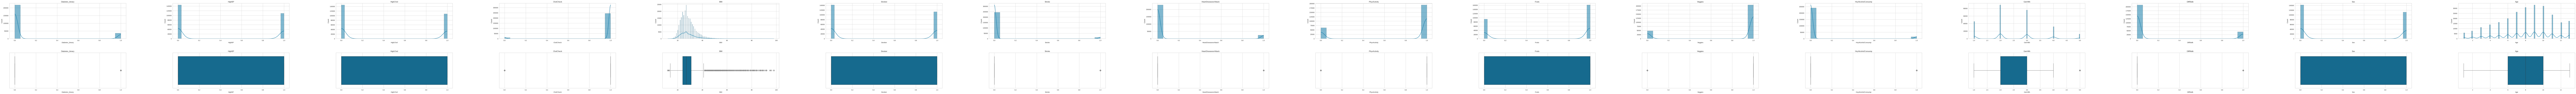

In [ ]:
datos_EDA = datos_f1.toPandas()
num_list = []
cat_list = []

fig, axes = plt.subplots(2, len(datos_EDA.columns), figsize=(300, 10))  # Ajusta el tamaño según sea necesario
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes = axes.flatten()

# Contador para los gráficos
graph_count = 0

# Iterar sobre las columnas del DataFrame
for column in datos_EDA.columns:
    if is_numeric_dtype(datos_EDA[column]):
        # Histograma en la primera fila
        sns.histplot(datos_EDA[column], kde=True, ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")

        # Boxplot en la segunda fila
        sns.boxplot(x=datos_EDA[column], ax=axes[graph_count + len(datos_EDA.columns)])
        axes[graph_count + len(datos_EDA.columns)].set_title(f"{column}")
        num_list.append(column)
        graph_count += 1  # Pasar al siguiente gráfico

    elif is_string_dtype(datos_EDA[column]):
        sns.countplot(data=datos_EDA, x=datos_EDA[column], ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")
        cat_list.append(column)
        axes[graph_count + len(datos_EDA.columns)].axis("off")
        graph_count += 1  # Pasar al siguiente gráfico

# Mostrar la gráfica
plt.show()


- El índice de masa corporal presenta una distribución sesgada a la derecha, con valores concentrados entre 20 y 40, y algunos valores atípicos más altos. Esto podría indicar obesidad severa en casos aislados.

- Las variables binarias presentan distribuciones desbalanceadas en algunos casos, lo cual indica baja ocurrencia de condiciones como accidentes cerebrovasculares o dificultad para caminar en la muestra. Esto es coherente con lo esperado en poblaciones generales.

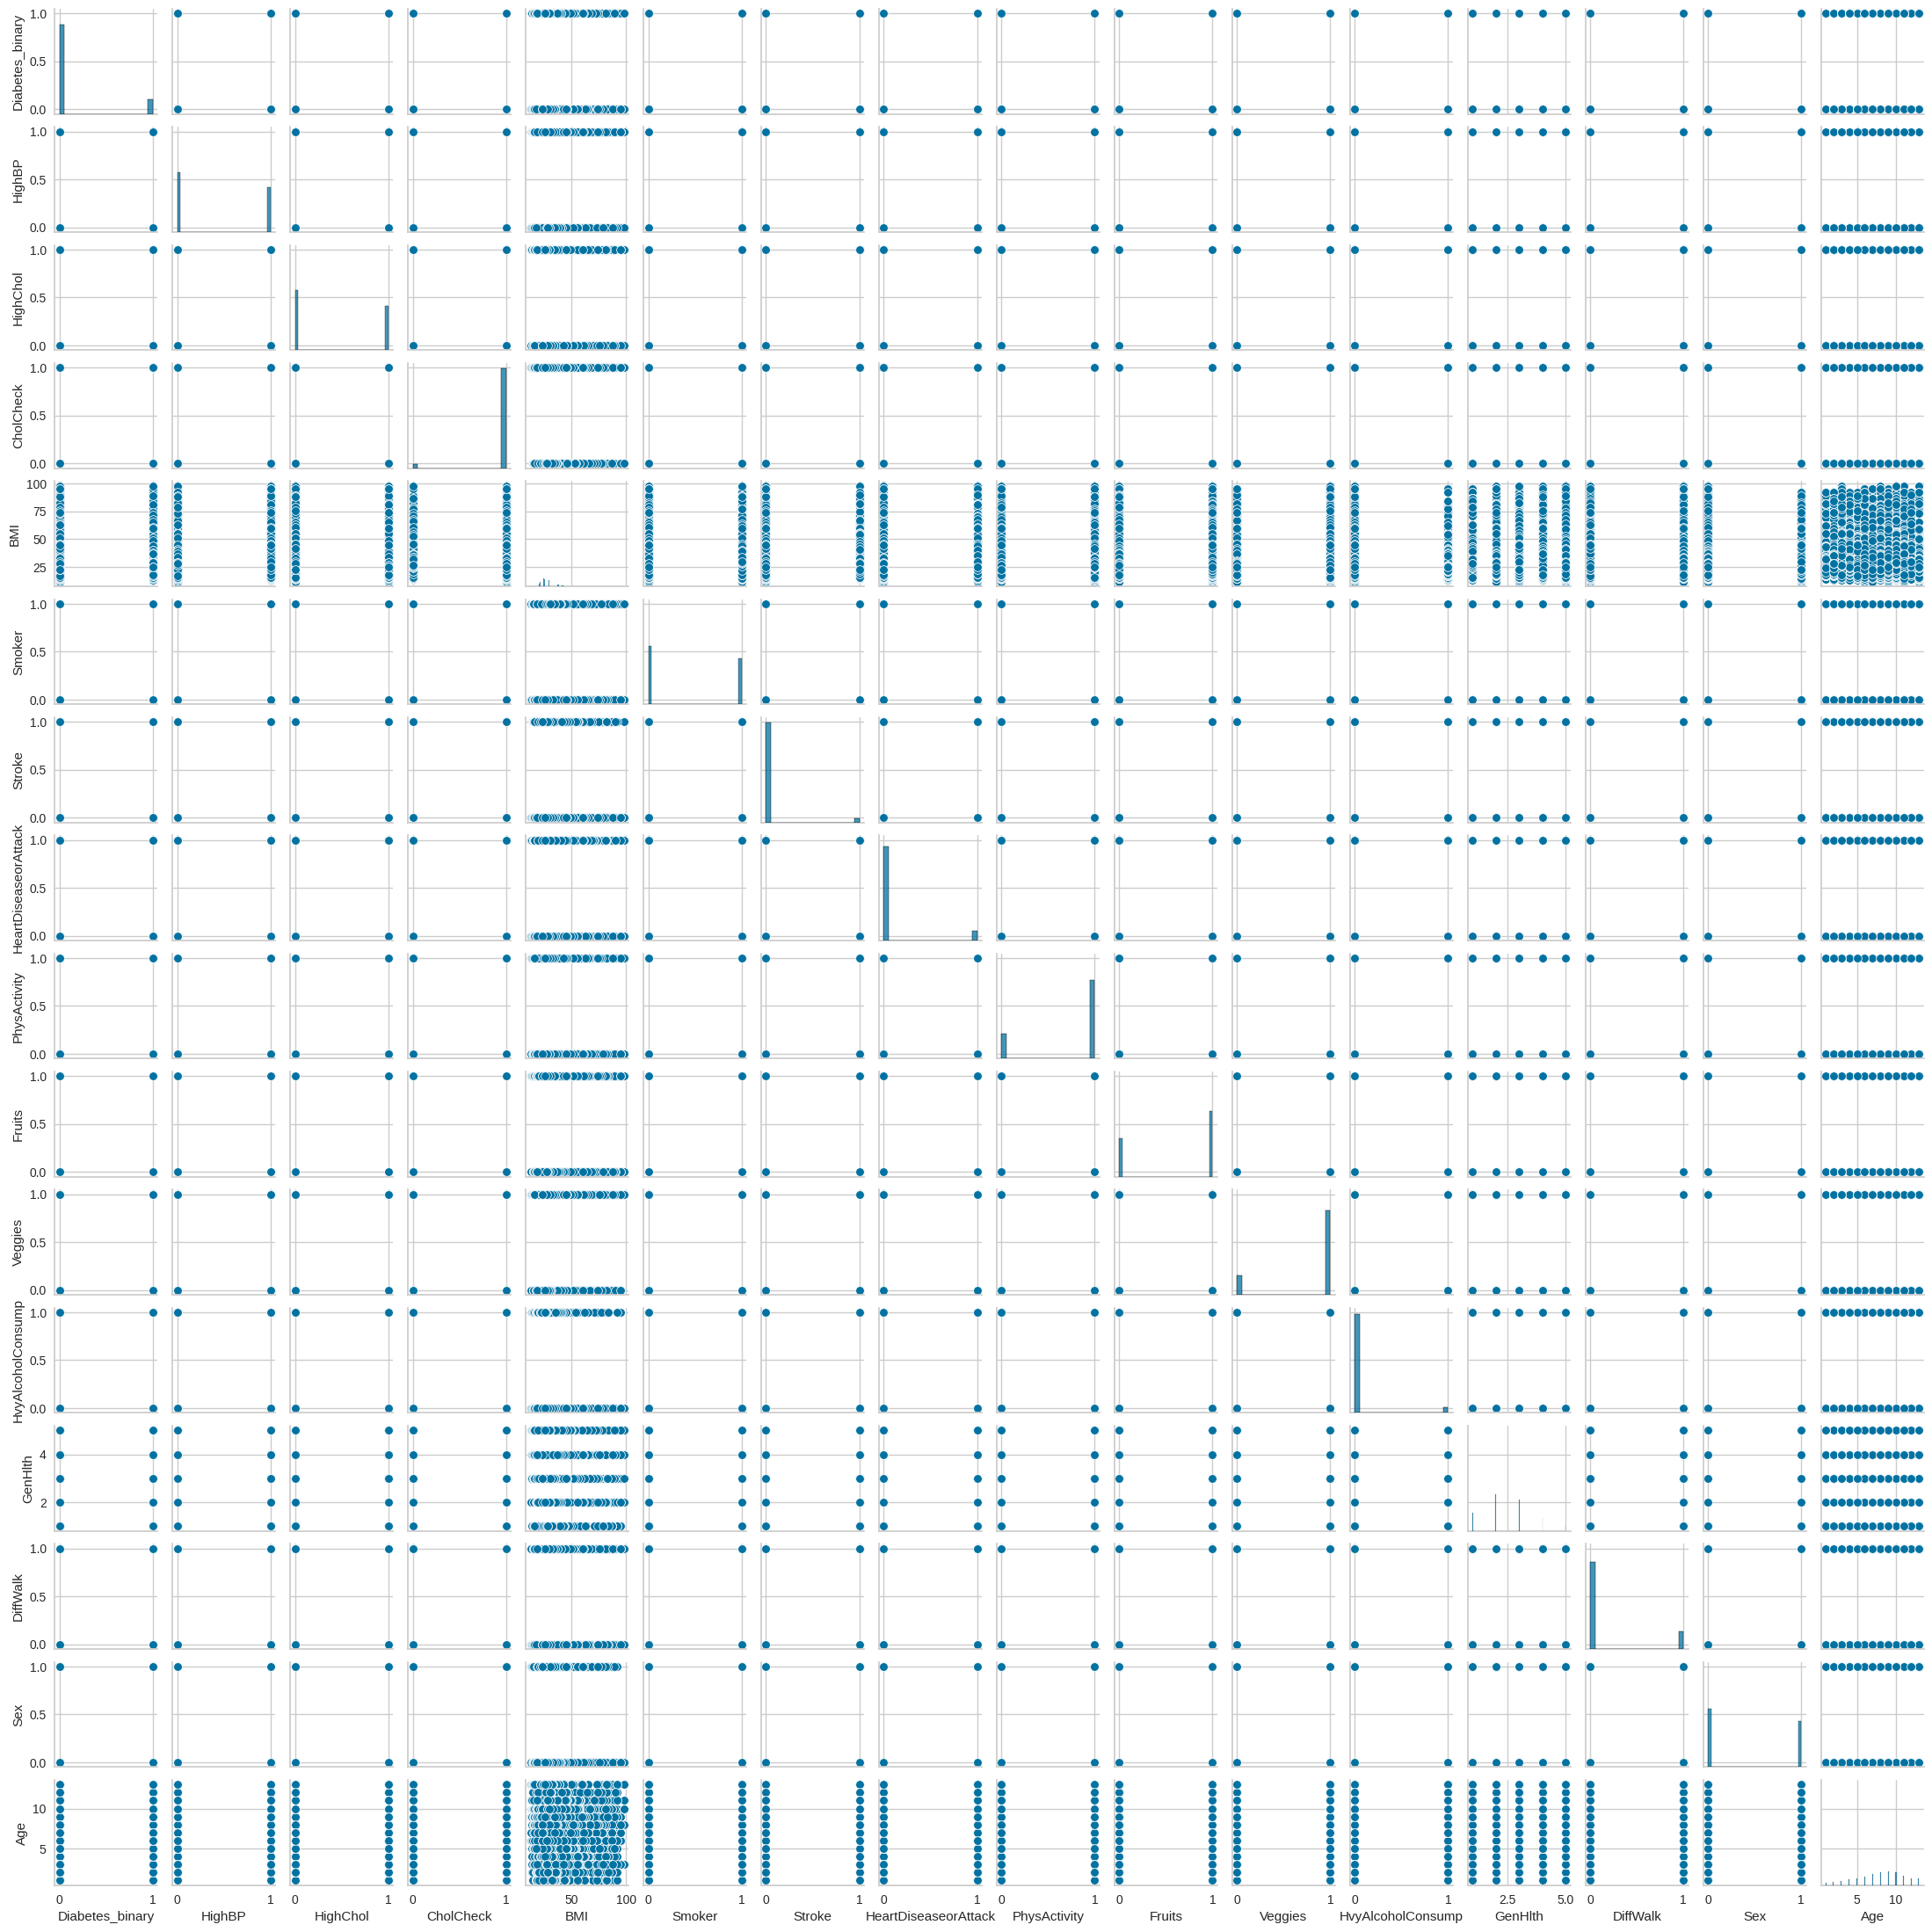

In [ ]:
numeric_data = datos.select(numeric_features).toPandas()
sns.pairplot(numeric_data, height=1.4)
plt.show()

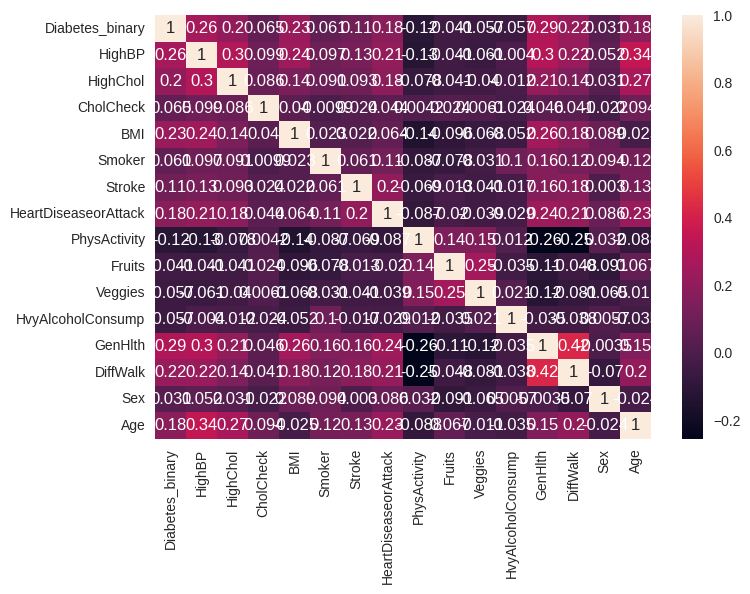

In [ ]:
sns.heatmap(numeric_data.corr('spearman'),annot=True)
plt.show()

La matriz de correlación permitió identificar las variables con mayor asociación lineal con el diagnóstico de diabetes. Se destacan HighBP, HighChol, BMI, GenHlth, DiffWalk, Age y HeartDiseaseorAttack, todas con valores de correlación superiores a 0.18. Estas variables fueron seleccionadas como candidatas principales para el modelo de clasificación. Se descartaron otras con baja correlación y limitada relevancia estadística, como Smoker, Fruits, Veggies y HvyAlcoholConsump, para reducir ruido en el modelo sin comprometer su interpretabilidad.

In [ ]:
datos_f2 = datos_f1.select(
    'HighBP',
    'HighChol',
    'BMI',
    'GenHlth',
    'DiffWalk',
    'Age',
    'HeartDiseaseorAttack',
    'PhysActivity',
    'CholCheck',
    'Stroke',
    'Diabetes_binary'
)

cols = datos_f2.columns
datos_f2.printSchema()


root
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- Diabetes_binary: double (nullable = true)



# **Tarea de Clasificacion**

In [ ]:
salida = 'Diabetes_binary'
caracteristicas = [car for car in cols if car not in salida]
cat_car = [c for c, t in datos_f2.dtypes if t == 'string' and c not in salida]
num_car = [c for c, t in datos_f2.dtypes if t in ['int', 'double'] and c not in salida]
print('Cat:',cat_car,'\nNum:', num_car)

Cat: [] 
Num: ['HighBP', 'HighChol', 'BMI', 'GenHlth', 'DiffWalk', 'Age', 'HeartDiseaseorAttack', 'PhysActivity', 'CholCheck', 'Stroke']


In [ ]:
indexers = [StringIndexer(inputCol = col,
                          outputCol = "c_{}".format(col)) for col in cat_car]

encoders = [OneHotEncoder(inputCol = "c_{}".format(col),
                          outputCol = "o_{}".format(col)) for col in cat_car]

assembler = VectorAssembler(inputCols = num_car + ["o_{}".format(col) for col in cat_car], outputCol = "features")

labelIndexer = StringIndexer(inputCol=salida, outputCol='label') if salida in datos_f2.columns else None

preprocessor = Pipeline(stages = indexers + encoders + [assembler] + [labelIndexer]).fit(datos_f2)


In [ ]:
datos_f3 = preprocessor.transform(datos_f2)
selectedCols = ['label', 'features'] #+ cols
datos_f4 = datos_f3.select(selectedCols)
datos_f4.printSchema()
datos_f4.show(5,truncate=False)

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)

+-----+-------------------------------------------+
|label|features                                   |
+-----+-------------------------------------------+
|0.0  |[1.0,1.0,40.0,5.0,1.0,9.0,0.0,0.0,1.0,0.0] |
|0.0  |(10,[2,3,5,7],[25.0,3.0,7.0,1.0])          |
|0.0  |[1.0,1.0,28.0,5.0,1.0,9.0,0.0,0.0,1.0,0.0] |
|0.0  |[1.0,0.0,27.0,2.0,0.0,11.0,0.0,1.0,1.0,0.0]|
|0.0  |[1.0,1.0,24.0,2.0,0.0,11.0,0.0,1.0,1.0,0.0]|
+-----+-------------------------------------------+
only showing top 5 rows



In [ ]:
train, test = datos_f4.randomSplit([0.7, 0.3], seed = 21777)
print("Division de conjuntos --------------------")
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Division de conjuntos --------------------
Training Dataset Count: 177604
Test Dataset Count: 76076


In [ ]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [ ]:
print(lrModel.coefficients)

[0.7832251349430421,0.585980607719353,0.06095323978272581,0.5357035148130269,0.0729241928915557,0.12872238563080227,0.26356271155693767,-0.058010155428864896,1.2007578820087106,0.16917335770360803]


**Evaluación de Resultados**

In [ ]:
def calculate_metrics(predictions, label_col):
    evaluator = BinaryClassificationEvaluator(labelCol=label_col)
    auc_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

    multi_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction")
    accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
    precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
    recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
    f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

    return {
        "AUC-ROC": auc_roc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

In [ ]:
def conf_matrix(y_log):
  fig, ax = plot_confusion_matrix(confusion_matrix(y_log.label, y_log.prediction), show_normed=True,
                                  figsize=(3,3))
  fig.show()


In [ ]:
train_predictions = lrModel.transform(train)
test_predictions = lrModel.transform(test)

#**Entrenamiento**

In [ ]:
print("Métricas en datos de entrenamiento:\n")
train_metrics = calculate_metrics(train_predictions, 'label')
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

Métricas en datos de entrenamiento:

AUC-ROC: 0.8190374346046451
Accuracy: 0.8629760590977681
Precision: 0.8280589074871854
Recall: 0.8629760590977681
F1 Score: 0.8279005863206044


El modelo demuestra un buen desempeño en el conjunto de entrenamiento, con métricas equilibradas y una AUC-ROC superior al 0.8, lo cual indica que el modelo logra diferenciar correctamente entre personas con y sin diabetes.

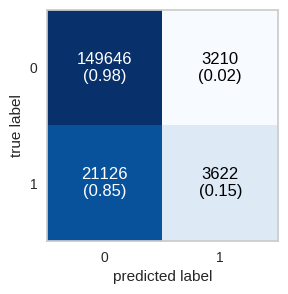

In [ ]:
conf_matrix(train_predictions.select('label','prediction').toPandas())

*Re-entrenamiento*

#**Prueba**

In [ ]:
print("\nMétricas en datos de prueba:\n")
test_metrics = calculate_metrics(test_predictions, 'label')
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")


Métricas en datos de prueba:

AUC-ROC: 0.8156959456615126
Accuracy: 0.8637415216362585
Precision: 0.8298738645099965
Recall: 0.8637415216362585
F1 Score: 0.8292184184995087


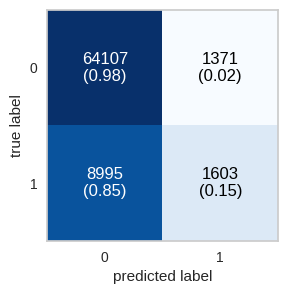

In [ ]:
conf_matrix(test_predictions.select('label','prediction').toPandas())

En los datos de prueba, el modelo mantiene un rendimiento muy similar al observado en entrenamiento, lo cual indica buena generalización y ausencia de sobreajuste. Las métricas clave se mantienen estables, lo cual respalda la robustez del modelo.

**En conclusion:**

El presente análisis tuvo como propósito explorar y modelar los factores de salud y estilo de vida que inciden en la probabilidad de desarrollar diabetes. Desde el inicio, se tomó la decisión de enfocar el estudio en variables relacionadas directamente con condiciones físicas y hábitos personales, excluyendo variables demográficas que, si bien relevantes en otros contextos, no se alineaban con el objetivo principal del proyecto.

Durante la etapa de depuración y exploración de datos, se identificaron patrones consistentes que reforzaron la selección de variables clave como la presión arterial alta, el colesterol alto, el índice de masa corporal, la percepción de salud general, la dificultad para caminar, y la presencia de enfermedades cardíacas. Estas variables mostraron una correlación significativa con el diagnóstico de diabetes y fueron incluidas en el modelo final, junto a algunas otras seleccionadas por su relevancia clínica.

La construcción del modelo de clasificación, arrojó métricas sólidas tanto en los datos de entrenamiento como en los de prueba. Con una AUC-ROC superior a 0.81 y un F1-score cercano al 83%, el modelo demostró un buen nivel de desempeño general y capacidad de generalización. No obstante, el análisis de la matriz de confusión reveló una sensibilidad reducida hacia la clase positiva (diabéticos), reflejo del desbalance natural del conjunto de datos.

# **Arbol de Decisión**

In [ ]:
dtc = DecisionTreeClassifier(labelCol="label", featuresCol="features")
paramGrid = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [5, 7, 9, 11, 13, 15]) \
    .build()


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

In [ ]:
crossval = CrossValidator(estimator=dtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [ ]:
cvModel = crossval.fit(train)

In [ ]:
best_model = cvModel.bestModel
print(f"Profundidad: {best_model._java_obj.getMaxDepth()}")
#print(f"Min Instances per Node: {best_model._java_obj.getMinInstancesPerNode()}")

Profundidad: 11


# **Validación**

In [ ]:
def calculate_metrics(predictions, label_col):
    evaluator = BinaryClassificationEvaluator(labelCol=label_col)
    auc_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

    multi_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction")
    accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
    precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
    recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
    f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

    return {
        "AUC-ROC": auc_roc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

In [ ]:
def conf_matrix(y):
  fig, ax = plot_confusion_matrix(confusion_matrix(y.label, y.prediction), show_normed=True,
                                  figsize=(3,3))
  fig.show()

In [ ]:
test_res = best_model.transform(test)
train_res = best_model.transform(train)

## Métricas de Rendimiento

### Entrenamiento

In [ ]:
print("Métricas en datos de entrenamiento:\n")
train_metrics = calculate_metrics(train_res, 'label')
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

Métricas en datos de entrenamiento:

AUC-ROC: 0.631131158729388
Accuracy: 0.8702731920452242
Precision: 0.8444178336542114
Recall: 0.8702731920452242
F1 Score: 0.837739222577403


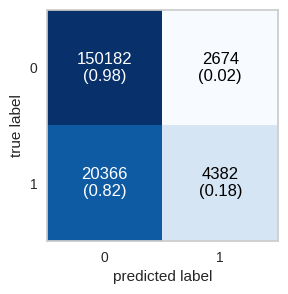

In [ ]:
conf_matrix(train_res.select('label','prediction').toPandas())

## Prueba

In [ ]:
print("\nMétricas en datos de prueba:\n")
test_metrics = calculate_metrics(test_res, 'label')
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")


Métricas en datos de prueba:

AUC-ROC: 0.6242791574259711
Accuracy: 0.863518060886482
Precision: 0.8294058859158513
Recall: 0.863518060886482
F1 Score: 0.8290195297587796


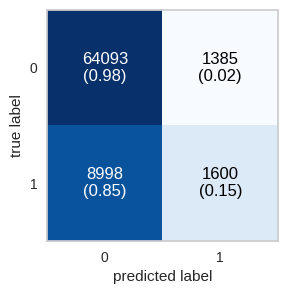

In [ ]:
conf_matrix(test_res.select('label','prediction').toPandas())

El modelo está funcionando bien. En los datos de entrenamiento y prueba, acierta en más del 85% de las predicciones. También es bueno para identificar bien los casos positivos, y no se pierde muchos. El puntaje F1 muestra que el modelo tiene un buen equilibrio entre no equivocarse y no dejar pasar casos importantes. En general, el modelo parece confiable y puede funcionar bien con datos nuevos.

# Segundo entrenamiento de modelos


En la primera etapa entrenamos el modelo con parámetros estándar y obtuvimos buenos resultados, con un AUC-ROC alrededor de 0.81 y métricas balanceadas tanto en entrenamiento como en prueba. Sin embargo, para mejorar el desempeño, realizamos un ajuste de parámetros clave usando validación cruzada, probando diferentes configuraciones.

# **Tarea de Clasificacion**

In [ ]:
salida = 'Diabetes_binary'
caracteristicas = [car for car in cols if car not in salida]
cat_car = [c for c, t in datos_f2.dtypes if t == 'string' and c not in salida]
num_car = [c for c, t in datos_f2.dtypes if t in ['int', 'double'] and c not in salida]
print('Cat:',cat_car,'\nNum:', num_car)

Cat: [] 
Num: ['HighBP', 'HighChol', 'BMI', 'GenHlth', 'DiffWalk', 'Age', 'HeartDiseaseorAttack', 'PhysActivity', 'CholCheck', 'Stroke']


In [ ]:
indexers = [StringIndexer(inputCol=col, outputCol=f"c_{col}") for col in cat_car]
encoders = [OneHotEncoder(inputCol=f"c_{col}", outputCol=f"o_{col}") for col in cat_car]
assembler = VectorAssembler(inputCols=num_car + [f"o_{col}" for col in cat_car], outputCol="features")
labelIndexer = StringIndexer(inputCol=salida, outputCol='label')


In [ ]:
preprocessor = Pipeline(stages=indexers + encoders + [assembler, labelIndexer]).fit(datos_f2)
datos_preparados = preprocessor.transform(datos_f2)
datos_final = datos_preparados.select(['label', 'features'])

In [ ]:
train, test = datos_final.randomSplit([0.7, 0.3], seed=21777)
print(f"Train count: {train.count()}, Test count: {test.count()}")

Train count: 177604, Test count: 76076


In [ ]:
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
lrModel = lr.fit(train)

In [ ]:
print(lrModel.coefficients)

[0.7832251349430421,0.585980607719353,0.06095323978272581,0.5357035148130269,0.0729241928915557,0.12872238563080227,0.26356271155693767,-0.058010155428864896,1.2007578820087106,0.16917335770360803]


**Evaluación de Resultados**

In [ ]:
def calculate_metrics(predictions, label_col):
    evaluator = BinaryClassificationEvaluator(labelCol=label_col)
    auc_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

    multi_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction")
    accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
    precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
    recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
    f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

    return {
        "AUC-ROC": auc_roc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

In [ ]:
def conf_matrix(y_log):
  fig, ax = plot_confusion_matrix(confusion_matrix(y_log.label, y_log.prediction), show_normed=True,
                                  figsize=(3,3))
  fig.show()


In [ ]:
train_predictions2 = lrModel.transform(train)
test_predictions2 = lrModel.transform(test)

#**Entrenamiento**

In [ ]:
print("Métricas en datos de entrenamiento:\n")
train_metrics = calculate_metrics(train_predictions2, 'label')
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

Métricas en datos de entrenamiento:

AUC-ROC: 0.819037426145482
Accuracy: 0.8629760590977681
Precision: 0.8280589074871854
Recall: 0.8629760590977681
F1 Score: 0.8279005863206044


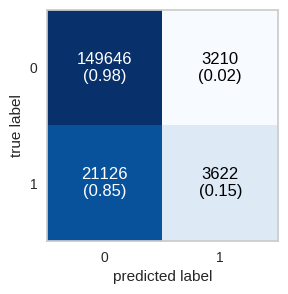

In [ ]:
conf_matrix(train_predictions2.select('label','prediction').toPandas())

*Re-entrenamiento*

#**Prueba**

In [ ]:
print("\nMétricas en datos de prueba:\n")
test_metrics = calculate_metrics(test_predictions2, 'label')
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")


Métricas en datos de prueba:

AUC-ROC: 0.8156959888931745
Accuracy: 0.8637415216362585
Precision: 0.8298738645099965
Recall: 0.8637415216362585
F1 Score: 0.8292184184995087


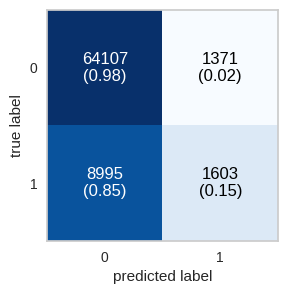

In [ ]:
conf_matrix(test_predictions2.select('label','prediction').toPandas())

# **Arbol de Decisión**

In [79]:
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10]) \
    .addGrid(dt.minInstancesPerNode, [1]) \
    .addGrid(dt.maxBins, [20, 32]) \
    .build()

In [80]:
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')


In [81]:

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [82]:
cvModel_dt = crossval.fit(train)

In [83]:
bestModel_dt = cvModel_dt.bestModel

print("Mejores parámetros árbol de decisión:")
print(f" maxDepth: {bestModel_dt._java_obj.getMaxDepth()}")
print(f" minInstancesPerNode: {bestModel_dt._java_obj.getMinInstancesPerNode()}")
print(f" maxBins: {bestModel_dt._java_obj.getMaxBins()}")

Mejores parámetros árbol de decisión:
 maxDepth: 10
 minInstancesPerNode: 1
 maxBins: 32


# **Validación**

In [84]:
def calculate_metrics(predictions, label_col):
    evaluator = BinaryClassificationEvaluator(labelCol=label_col)
    auc_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

    multi_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction")
    accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
    precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
    recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
    f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

    return {
        "AUC-ROC": auc_roc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

In [85]:
def conf_matrix(y):
  fig, ax = plot_confusion_matrix(confusion_matrix(y.label, y.prediction), show_normed=True,
                                  figsize=(3,3))
  fig.show()

In [86]:
test_res = bestModel_dt.transform(test)
train_res = bestModel_dt.transform(train)

## Métricas de Rendimiento

### Entrenamiento

In [87]:
print("Métricas en datos de entrenamiento:\n")
train_metrics = calculate_metrics(train_res, 'label')
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

Métricas en datos de entrenamiento:

AUC-ROC: 0.6255376194447527
Accuracy: 0.868189905632756
Precision: 0.8398400811617578
Recall: 0.868189905632756
F1 Score: 0.83550190412239


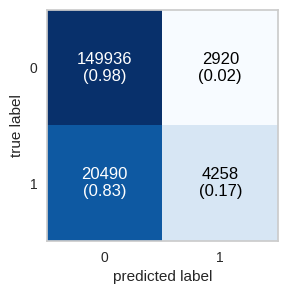

In [88]:
conf_matrix(train_res.select('label','prediction').toPandas())

## Prueba

In [89]:
print("\nMétricas en datos de prueba:\n")
test_metrics = calculate_metrics(test_res, 'label')
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")


Métricas en datos de prueba:

AUC-ROC: 0.6179151750230096
Accuracy: 0.8647273778852727
Precision: 0.8322030303706741
Recall: 0.8647273778852727
F1 Score: 0.8309130486470003


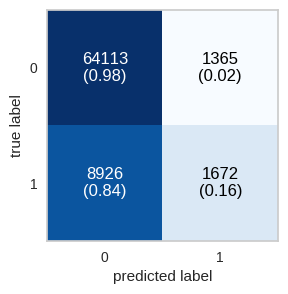

In [90]:
conf_matrix(test_res.select('label','prediction').toPandas())

Los resultados obtenidos en la segunda evaluación del árbol de decisión muestran métricas muy similares a las de la primera fase, especialmente en términos de accuracy, precision, recall y F1 Score. Aunque el AUC-ROC presentó una ligera disminución, esta variación es mínima y puede estar dentro del rango esperado por la variabilidad natural del modelo y los datos. Esto sugiere que el ajuste de parámetros realizado no generó una mejora significativa en la capacidad discriminativa del modelo, pero sí mantuvo un desempeño robusto y consistente. Por lo tanto, el árbol de decisión con parámetros estándar ya ofrecía un rendimiento estable, y los ajustes realizados no impactaron de manera notable la efectividad del modelo para clasificar correctamente los casos de diabetes.